In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import torch
import numpy as np
import pandas as pd
import h5py
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import pyplot as plt, cm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from adni_util import get_cohort_data, get_normalized_data
from cvae_train import train_cvae, load_model, cvae_loss_fn, cVAE_PET, PETDataset, create_hdf5_dataset
from demographics import get_age_and_education, merge_tables

In [ ]:
AD_COHORT_DIR = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/AD_Cohort'
AD_COHORT_PET_NORM_DIR = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/ad_cohort_norm'
# AD_COHORT_DIR = '/home/hice1/khom9/CS8903/AD_Cohort'
MCI_COHORT_DIR = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/MCI_Cohort'
MCI_COHORT_NORM_DIR = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/MCI_cohort_norm'
CDR_MAX_SCORE = 18

DEVICE = (f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
all_cohorts_path = '/home/hice1/khom9/CS8903/all_cohorts_cvae.csv'
ad_hdf5_path = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/AD_Cohort.hdf5'
mci_hdf5_path = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/MCI_Cohort.hdf5'
cn_hdf5_path = '/home/hice1/khom9/scratch/ADNI_Data/cVAE/CN_Cohort.hdf5'

In [ ]:
# create_cohort_hdf5(ad_hdf5_path, AD_COHORT_PET_NORM_DIR) # Only run once per cohort
# create_cohort_hdf5(mci_hdf5_path, MCI_COHORT_NORM_DIR) # Only run once per cohort
# create_cohort_hdf5(cn_hdf5_path, CN_COHORT_NORM_DIR) # Only run once per cohort

NameError: name 'CN_COHORT_NORM_DIR' is not defined

In [11]:
ad_dataset = PETDataset(ad_hdf5_path, all_cohorts_path, normalize='scale')
# mci_dataset = PETDataset(mci_hdf5_path, all_cohorts_path, diagnosis=2, normalize='scale')

# Dataset to use for the following analysis
dataset = ad_dataset

In [134]:
batch_size = 32
lr = 1e-4
latent_dim = 10
model = cVAE_PET(latent_dim).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 300
save_path = 'cvae-models/cvae_ad_scale_3.pth'

# model = load_model(model, save_path)
train_model(model, optimizer, ad_dataset, cvae_loss_fn, epochs=epochs, batch_size=batch_size, device=DEVICE, save_freq=25, save_path=save_path)

Learning rate: 0.0001
No learning rate scheduling!
Training for 300 epochs, with batch size=32
Using device: cuda:0
Saving model every 25 epochs to cvae-models/cvae_ad_scale_3.pth

-----Epoch 1/300-----
Batch 10/27, loss: 601779.09375 (0.815s)
Batch 20/27, loss: 600869.325 (0.815s)
Batch 27/27, loss: 599609.0803571428 (0.503s)

-----Epoch 2/300-----
Batch 10/27, loss: 592439.6375 (0.815s)
Batch 20/27, loss: 581263.925 (0.814s)
Batch 27/27, loss: 570726.6785714285 (0.502s)

-----Epoch 3/300-----
Batch 10/27, loss: 555370.975 (0.814s)
Batch 20/27, loss: 536479.703125 (0.815s)
Batch 27/27, loss: 500970.6651785714 (0.502s)

-----Epoch 4/300-----
Batch 10/27, loss: 468929.453125 (0.814s)
Batch 20/27, loss: 439474.99375 (0.814s)
Batch 27/27, loss: 423408.72321428574 (0.503s)

-----Epoch 5/300-----
Batch 10/27, loss: 405138.94375 (0.815s)
Batch 20/27, loss: 378720.98125 (0.814s)
Batch 27/27, loss: 372479.6473214286 (0.503s)

-----Epoch 6/300-----
Batch 10/27, loss: 361605.965625 (0.814s)
Batc

In [135]:
x, y = next(iter(DataLoader(dataset, batch_size=32, shuffle=True)))

In [136]:
x = x.to(DEVICE)
y = y.to(DEVICE)
xhat, mu, logvar = model(x,y)

In [132]:
xhat.shape

torch.Size([32, 1, 90, 108, 90])

In [133]:
cvae_loss_fn(x, xhat, mu, logvar)

torch.Size([32, 10]) torch.Size([32, 10])
tensor(83.3532, device='cuda:0', grad_fn=<MeanBackward0>)


tensor(303267.2812, device='cuda:0', grad_fn=<AddBackward0>)

In [137]:
model.eval()
with torch.no_grad():
    _, mu, logvar = model(torch.Tensor(dataset.imgs).unsqueeze(1).to(DEVICE), torch.Tensor(dataset.cdr_scores).to(DEVICE))
    mu = mu.cpu().numpy()

In [147]:
kmeans = KMeans(n_clusters=4)
clust = kmeans.fit_predict(mu)

In [148]:
tsne = TSNE()
t_comp = tsne.fit_transform(mu)

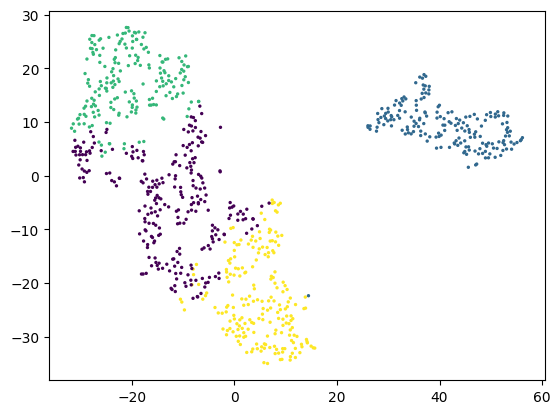

In [168]:
plt.scatter(t_comp[:,0], t_comp[:,1], c=clust, s=2)

In [150]:
def plot_elbows(data, max_clusters):
    '''Plot K means within-cluster sum of squares (WCSS) vs. number of clusters'''
    all_wcss = []
    dist_func = lambda x,y: (np.sum((x-y)**2))
    
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k).fit(data)
#         clusters = kmeans.cluster_centers_
#         clust_ids = kmeans.predict(data)
#         cur_wcss = 0.
#         for i in range(data.shape[0]):
#             clust_id = clust_ids[i]
#             cur_wcss += dist_func(data[i], clusters[clust_id])
        cur_wcss = kmeans.inertia_
        all_wcss.append(cur_wcss)
    
    fig, ax = plt.subplots()
    ax.plot(range(1, max_clusters+1), all_wcss)
    ax.scatter(range(1, max_clusters+1), all_wcss)
        

In [151]:
def plot_silhouette(X, tsne_proj, n_clusters, plot=True):
    '''
    Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    X: (n_samples, n_features) data to cluster
    tsne_proj: (n_samples, 2) the t-SNE projection of X into 2 dimensions
    n_clusters: (int) number of clusters to consider
    plot: whether to plot the total silhouette values per cluster as well as the t-SNE plot (True) and return mean silhouette score, 
          or to just return the mean silhouette score (False).
    '''
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    clust = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, clust)
    if not plot:
        return silhouette_avg
    
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])



    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, clust)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clust == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(clust.astype(float) / n_clusters)
    ax2.scatter(
        tsne_proj[:, 0], tsne_proj[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    # centers = tsne.transform(kmeans.cluster_centers_)
    # # Draw white circles at cluster centers
    # ax2.scatter(
    #     centers[:, 0],
    #     centers[:, 1],
    #     marker="o",
    #     c="white",
    #     alpha=1,
    #     s=200,
    #     edgecolor="k",
    # )

    # for i, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

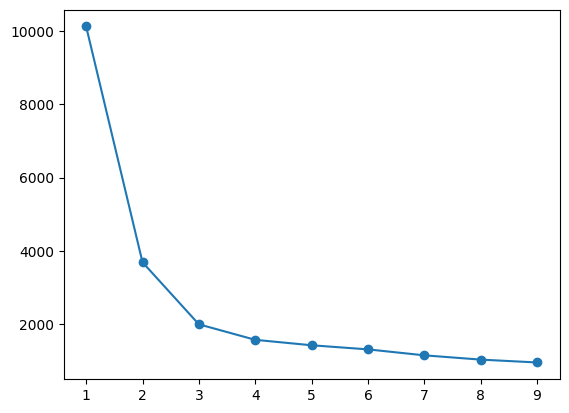

In [169]:
plot_elbows(mu, 9)

For n_clusters = 2 The average silhouette_score is : 0.6125006079673767
For n_clusters = 3 The average silhouette_score is : 0.48013409972190857
For n_clusters = 4 The average silhouette_score is : 0.40033093094825745
For n_clusters = 5 The average silhouette_score is : 0.3718862533569336
For n_clusters = 6 The average silhouette_score is : 0.34859853982925415


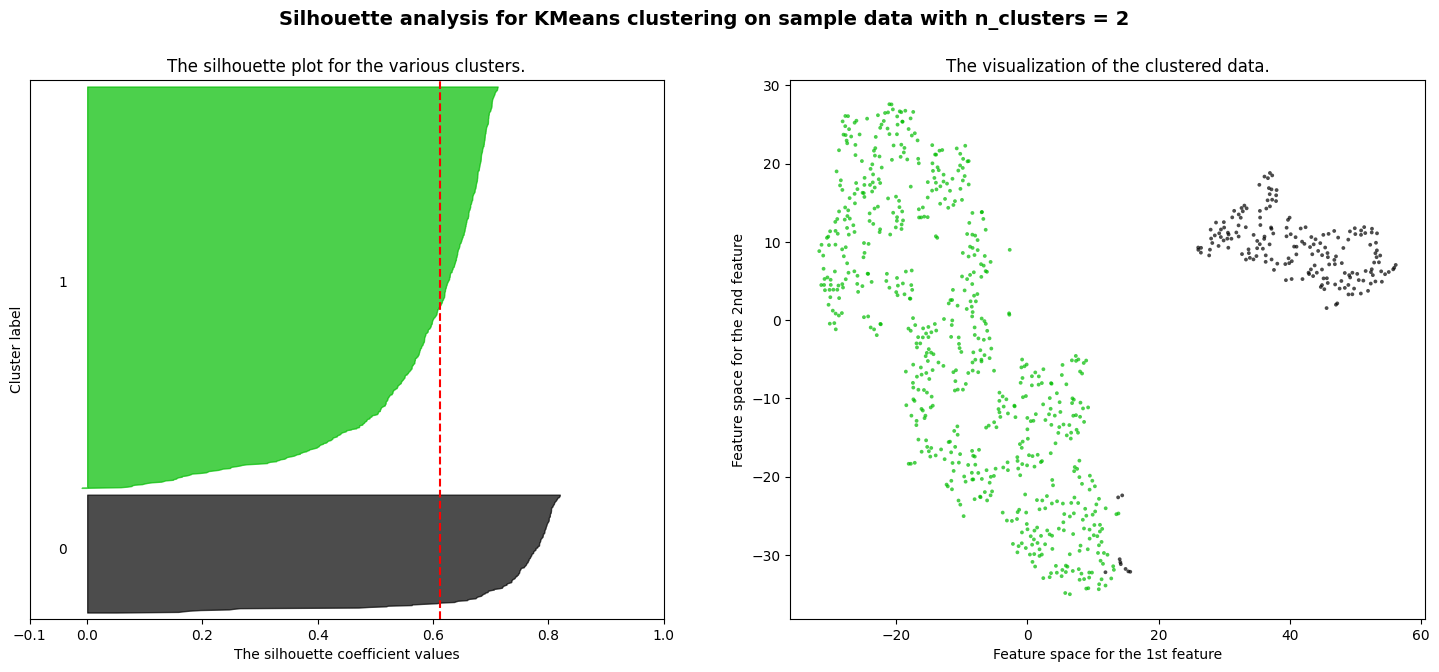

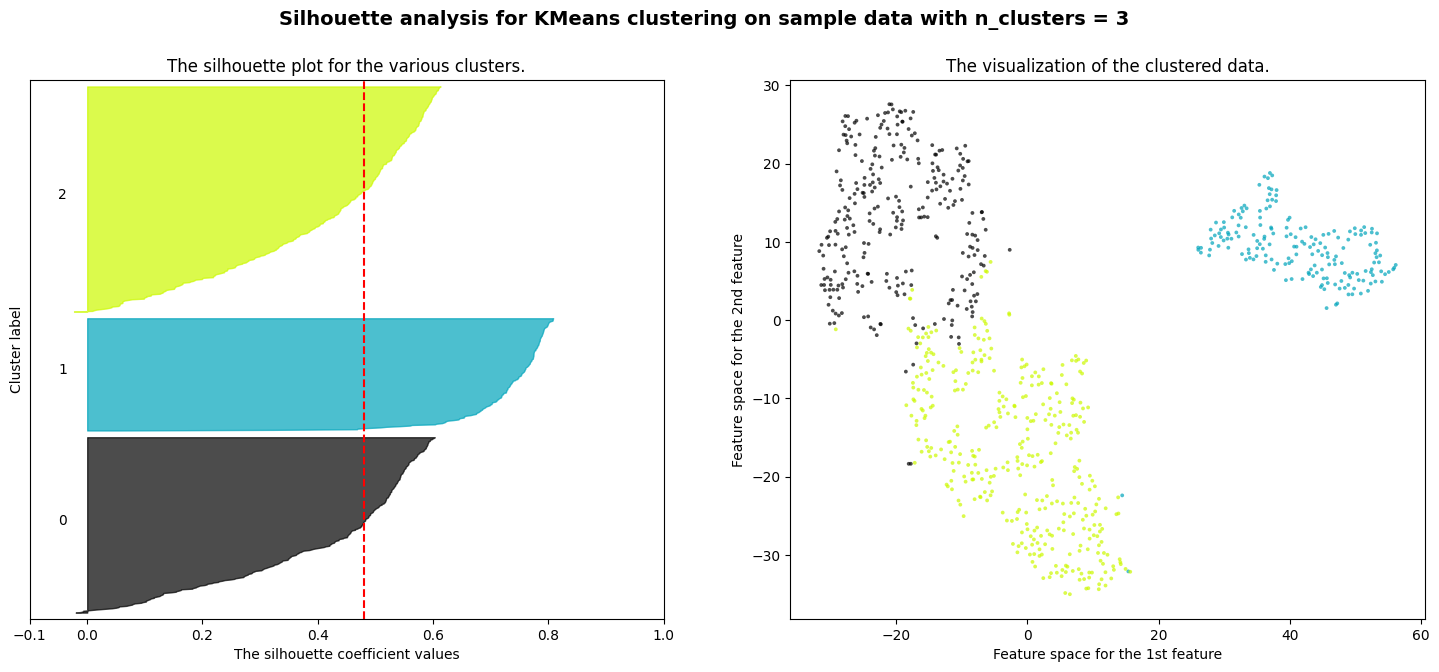

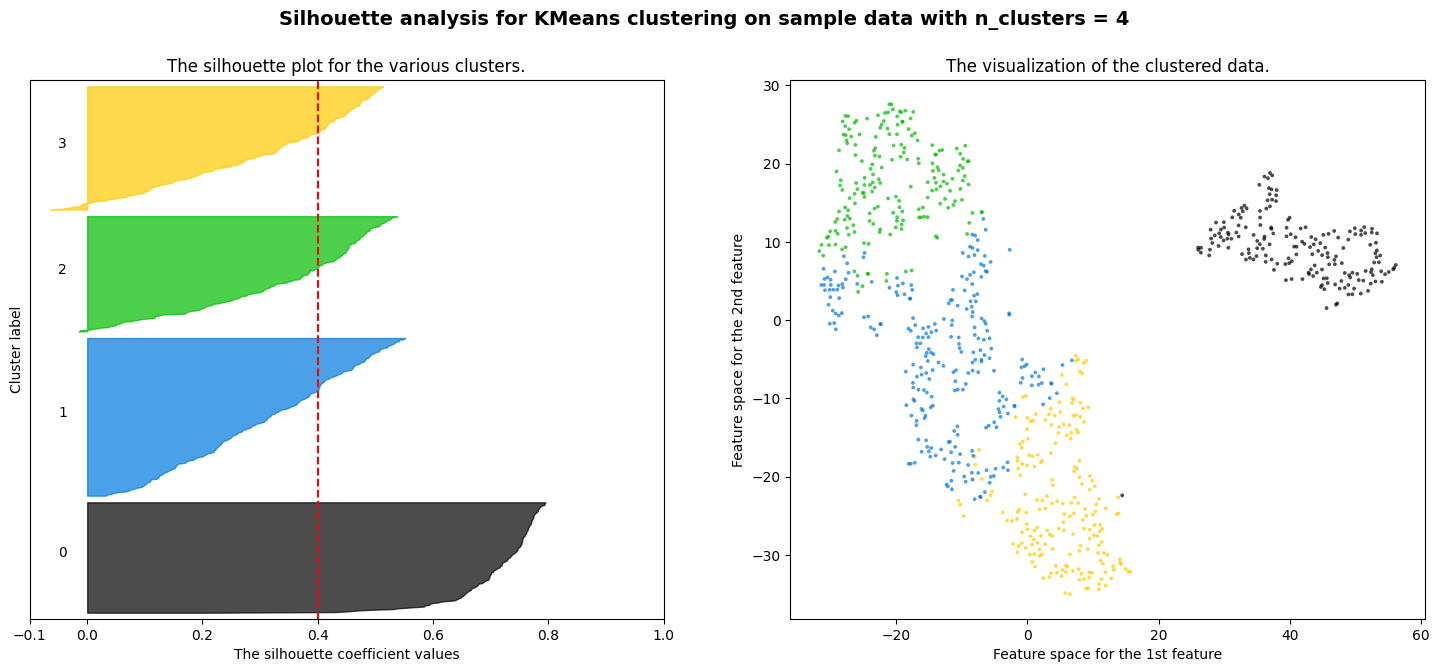

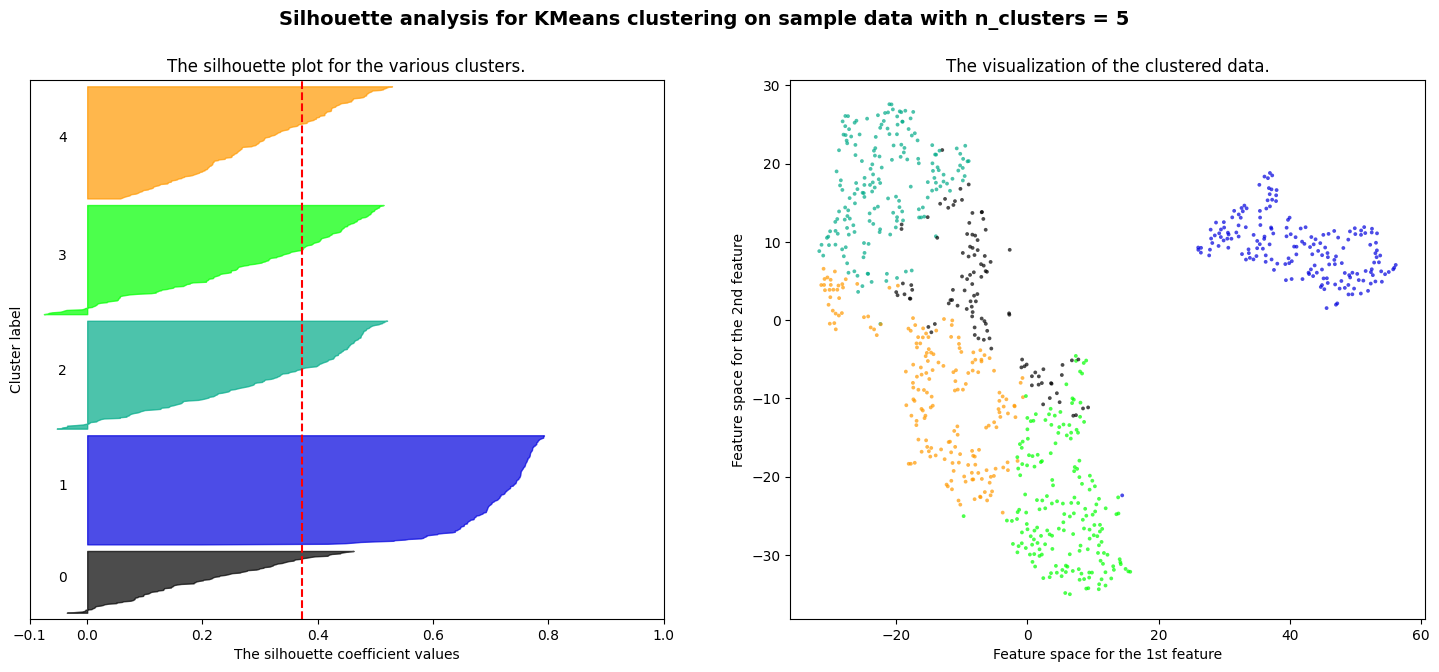

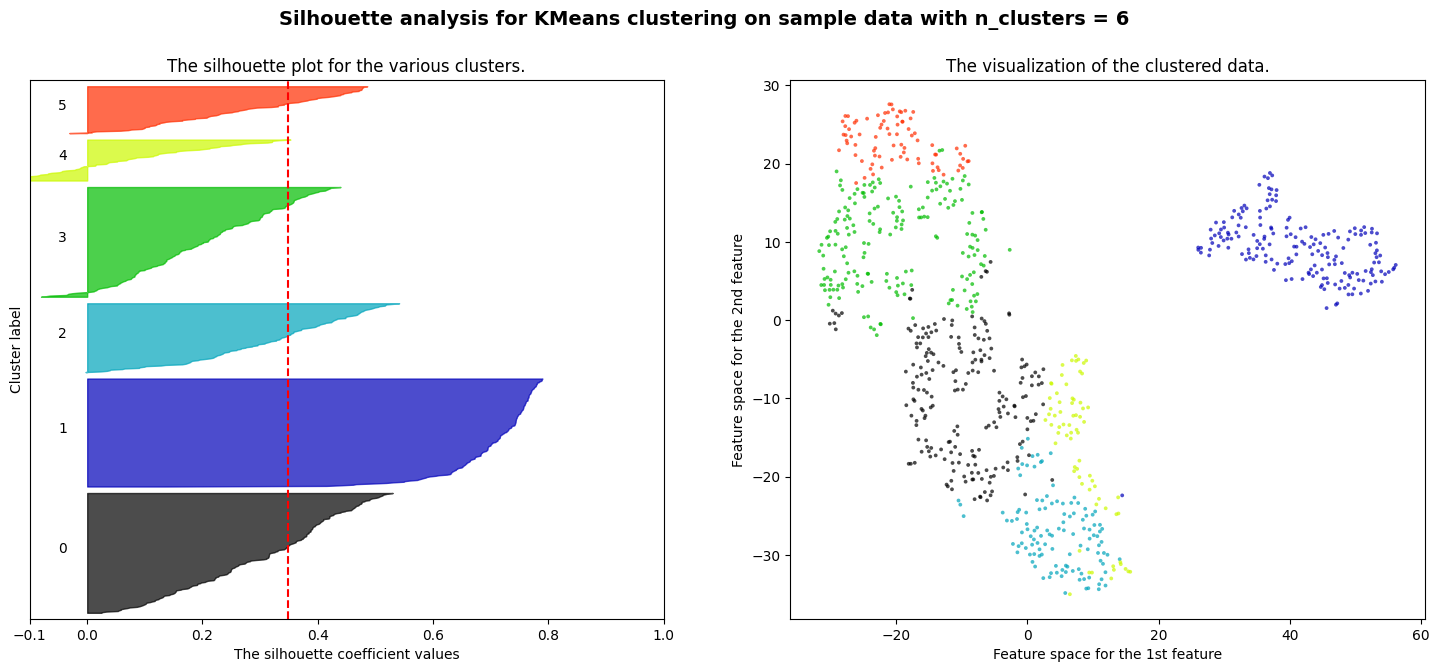

In [170]:
for k in [2,3,4,5,6]:
    plot_silhouette(mu, t_comp, n_clusters=k, plot=True)

In [154]:
dfs = [
    get_age_and_education(dataset.img_ids.tolist(), DEMOGRAPHIC_PATH, PET_METADATA_PATH),
    pd.read_csv(CDRSB_PATH, parse_dates=['VISDATE']),
    pd.read_csv(MMSE_PATH, parse_dates=['VISDATE']),
    pd.read_csv(MOCA_PATH, parse_dates=['VISDATE']),
    pd.read_csv(AV45_PATH, parse_dates=['SCANDATE']),
    pd.read_csv(PHC_PATH, parse_dates=['EXAMDATE']),
    pd.read_csv(CSF_PATH, parse_dates=['EXAMDATE'])
]
apoe = pd.read_csv(APOE_PATH)

NameError: name 'DEMOGRAPHIC_PATH' is not defined

In [21]:
id_cols = ['subject_id', 'PTID', 'PTID', 'PTID', 'PTID', 'PTID', 'PTID']
date_cols = ['image_date', 'VISDATE', 'VISDATE', 'VISDATE', 'SCANDATE', 'EXAMDATE', 'EXAMDATE']
keep_cols = [
    ['image_id', 'subject_id', 'image_date', 'PTEDUCAT', 'PTGENDER', 'age'],
    ['CDRSB'],
    ['MMSCORE'],
    ['MOCA'],
    ['SUMMARY_SUVR'],
    ['PHC_VSP', 'PHC_LAN', 'PHC_MEM', 'PHC_EXF'],
    ['TAU', 'PTAU', 'ABETA42']
]
apoe_cols = ['PTID', 'GENOTYPE']

df = merge_tables(dfs, id_cols, date_cols, keep_cols)
df = pd.merge(df, apoe[apoe_cols], how='left', left_on='subject_id', right_on='PTID').drop('PTID', axis=1)
df['apoe4'] = df['GENOTYPE'].str.contains('4').astype(float)
df = df.set_index('image_id')
df['cluster'] = pd.Series(index=dataset.img_ids, data=clust)

In [22]:
df

,subject_id,image_date,PTEDUCAT,PTGENDER,age,CDRSB,MMSCORE,MOCA,SUMMARY_SUVR,PHC_VSP,PHC_LAN,PHC_MEM,PHC_EXF,TAU,PTAU,ABETA42,GENOTYPE,apoe4,cluster
image_id,,,,,,,,,,,,,,,,,,,
117818,127_S_1427,2008-08-29,12.0,2.0,70.658453,4.0,20.0,NaN,0.946,-0.189,-0.257,-1.395,-0.874,NaN,NaN,NaN,3/3,0.0,1
139479,127_S_1427,2009-03-06,12.0,2.0,71.175907,6.0,15.0,NaN,0.946,-1.181,-1.021,-1.455,-1.561,NaN,NaN,NaN,3/3,0.0,3
154847,127_S_1427,2009-09-04,12.0,2.0,71.674196,4.5,20.0,NaN,0.946,-2.409,-0.941,-1.260,-1.787,NaN,NaN,NaN,3/3,0.0,3
191561,127_S_1427,2010-08-20,12.0,2.0,72.632444,5.0,14.0,NaN,0.946,-2.028,-1.133,-1.505,-2.094,NaN,NaN,NaN,3/3,0.0,0
340449,127_S_1427,2012-08-17,12.0,2.0,74.625599,4.5,18.0,NaN,1.164,-1.003,-0.796,-1.035,-1.797,NaN,NaN,NaN,3/3,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256913,341_S_6820,2019-11-08,12.0,1.0,68.438056,3.5,20.0,12.0,1.563,-1.059,-0.242,-0.323,-1.382,NaN,NaN,NaN,4/4,1.0,3
1308723,123_S_6825,2019-10-25,18.0,2.0,73.399042,1.0,24.0,20.0,1.437,0.907,0.110,-0.679,-0.264,319.6,31.8,599.9,3/4,1.0,0
1265230,168_S_6828,2019-12-09,12.0,1.0,81.522245,1.5,24.0,16.0,1.713,-0.198,0.146,-0.540,-0.311,NaN,NaN,NaN,3/3,0.0,3


[0.6160337552742616, 0.36813186813186816, 0.12878787878787878, 0.4131944444444444]


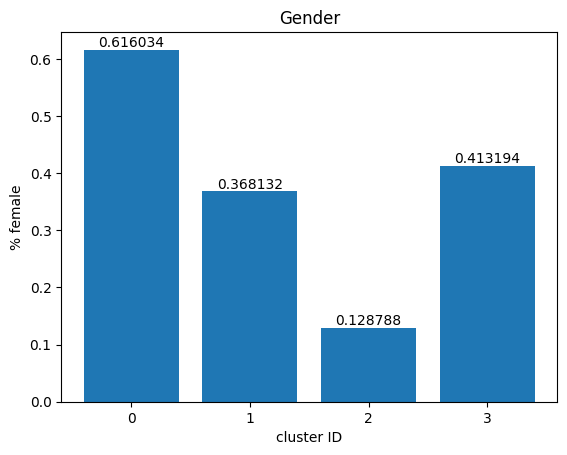

In [23]:
# Gender
fig, ax = plt.subplots()

means = [(df[df['cluster'] == i]['PTGENDER'] == 2).mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_xlabel('cluster ID')
ax.set_ylabel('% female')
ax.set_title('Gender')
ax.bar_label(bars)
print(means)

[75.50196530322852, 77.24626366104805, 76.40206998112541, 76.80174347859153]


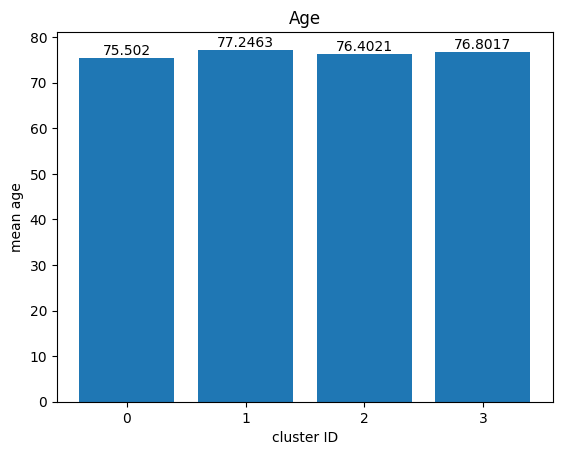

In [24]:
# Age
fig, ax = plt.subplots()

# df[df['cluster'] == 0]['age'].hist(ax=ax[0], alpha=0.3)
# df[df['cluster'] == 1]['age'].hist(ax=ax[0], alpha=0.3)
# df[df['cluster'] == 2]['age'].hist(ax=ax[0], alpha=0.3)
# df[df['cluster'] == 3]['age'].hist(ax=ax[0], alpha=0.3)

means = [df[df['cluster'] == i]['age'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('Age')
ax.set_xlabel('cluster ID')
ax.set_ylabel('mean age')
ax.bar_label(bars)

print(means)

[15.573839662447257, 14.703296703296703, 16.62121212121212, 15.229166666666666]


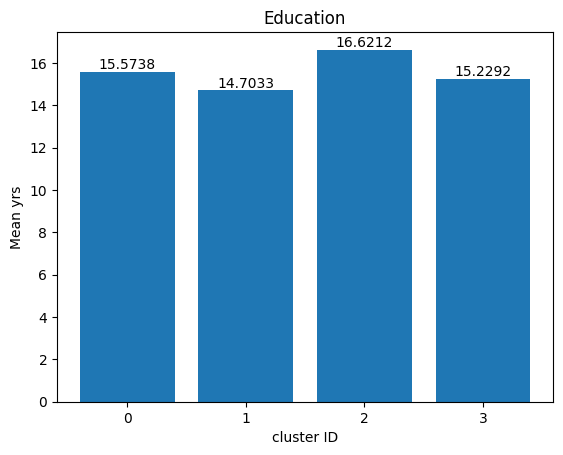

In [25]:
# Education
fig, ax = plt.subplots()

# df[df['cluster'] == 0]['PTEDUCAT'].hist(ax=ax[0], alpha=0.5)
# df[df['cluster'] == 1]['PTEDUCAT'].hist(ax=ax[0], alpha=0.5)
# df[df['cluster'] == 2]['PTEDUCAT'].hist(ax=ax[0], alpha=0.5)
# df[df['cluster'] == 3]['PTEDUCAT'].hist(ax=ax[0], alpha=0.5)

means = [df[df['cluster'] == i]['PTEDUCAT'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('Education')
ax.set_xlabel('cluster ID')
ax.set_ylabel('Mean yrs')
ax.bar_label(bars)

print(means)

[5.432489451476793, 5.197802197802198, 5.53030303030303, 5.321180555555555]


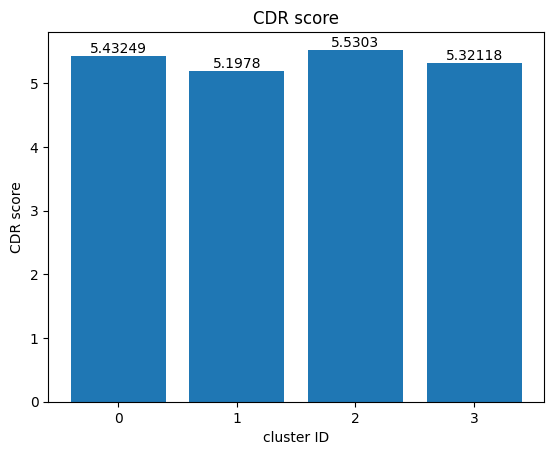

In [26]:
# CDR score
fig, ax = plt.subplots()

means = [df[df['cluster'] == i]['CDRSB'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('CDR score')
ax.set_xlabel('cluster ID')
ax.set_ylabel('CDR score')
ax.bar_label(bars)

print(means)

[22.135593220338983, 22.571428571428573, 21.5, 22.07638888888889]


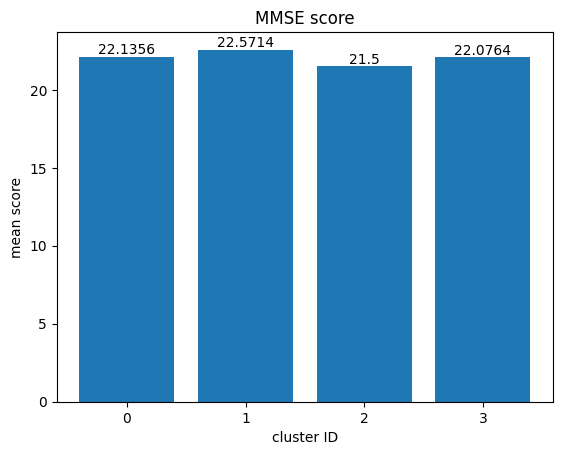

In [27]:
# MMSE score
fig, ax = plt.subplots()

means = [df[df['cluster'] == i]['MMSCORE'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('MMSE score')
ax.set_xlabel('cluster ID')
ax.set_ylabel('mean score')
ax.bar_label(bars)

print(means)

[17.06896551724138, 10.0, 18.352941176470587, 17.464285714285715]


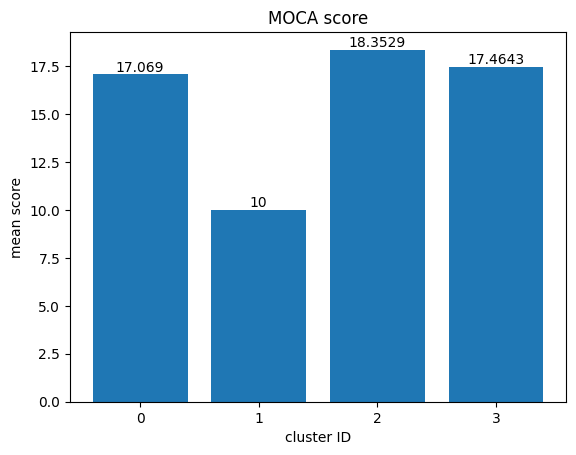

In [28]:
# MOCA score
# Has a lot of missing values!
fig, ax = plt.subplots()

means = [df[df['cluster'] == i]['MOCA'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('MOCA score')
ax.set_xlabel('cluster ID')
ax.set_ylabel('mean score')
ax.bar_label(bars)

print(means)

[-0.9022742616033756, -0.8726318681318681, -0.9406439393939393, -0.9127465277777778]


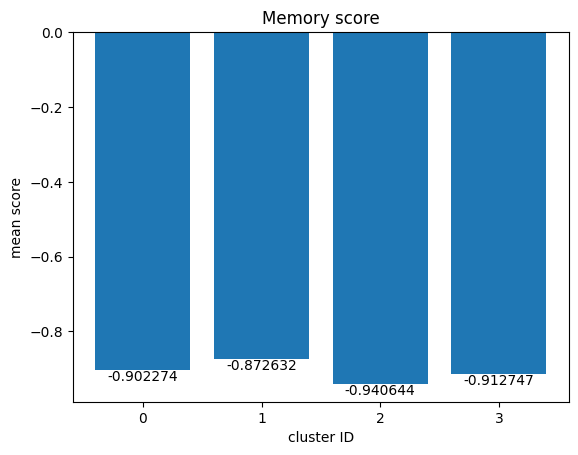

In [29]:
# PHC Memory score
fig, ax = plt.subplots()

means = [df[df['cluster'] == i]['PHC_MEM'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('Memory score')
ax.set_xlabel('cluster ID')
ax.set_ylabel('mean score')
ax.bar_label(bars)

print(means)

[-0.46126160337552746, -0.5107527472527473, -0.6096287878787878, -0.48988541666666663]


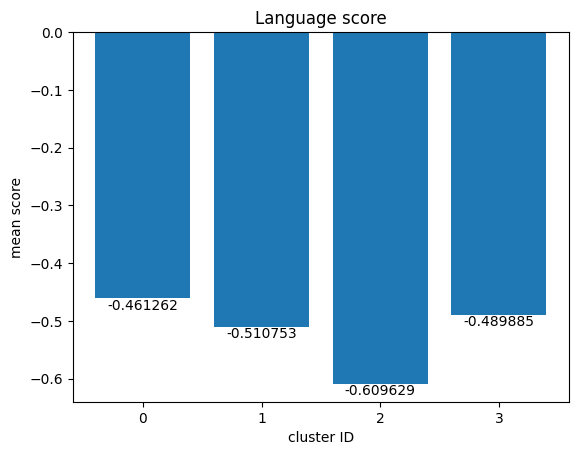

In [30]:
# PHC executive function score
fig, ax = plt.subplots()

means = [df[df['cluster'] == i]['PHC_EXF'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('Language score')
ax.set_xlabel('cluster ID')
ax.set_ylabel('mean score')
ax.bar_label(bars)

print(means)

[-0.3156160337552743, -0.2616868131868132, -0.36920454545454545, -0.30956249999999996]


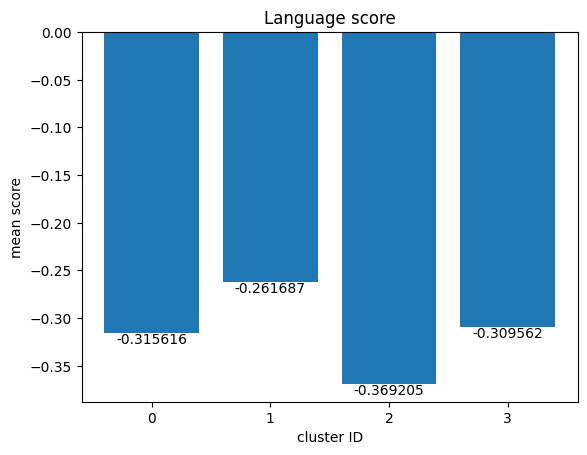

In [31]:
# PHC Language score
fig, ax = plt.subplots()

means = [df[df['cluster'] == i]['PHC_LAN'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('Language score')
ax.set_xlabel('cluster ID')
ax.set_ylabel('mean score')
ax.bar_label(bars)

print(means)

[-0.14540506329113922, -0.21195604395604392, -0.2749621212121212, -0.21168402777777776]


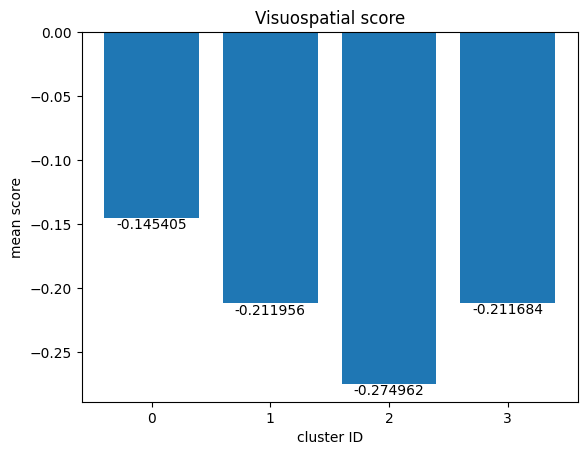

In [32]:
# Visuospatial score
fig, ax = plt.subplots()

# df[df['cluster'] == 0]['MMSCORE'].hist(ax=ax[0], alpha=0.5)
# df[df['cluster'] == 1]['MMSCORE'].hist(ax=ax[0], alpha=0.5)
# df[df['cluster'] == 2]['MMSCORE'].hist(ax=ax[0], alpha=0.5)
# df[df['cluster'] == 3]['MMSCORE'].hist(ax=ax[0], alpha=0.5)

means = [df[df['cluster'] == i]['PHC_VSP'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('Visuospatial score')
ax.set_xlabel('cluster ID')
ax.set_ylabel('mean score')
ax.bar_label(bars)

print(means)

[0.6371308016877637, 0.7197802197802198, 0.6363636363636364, 0.662020905923345]


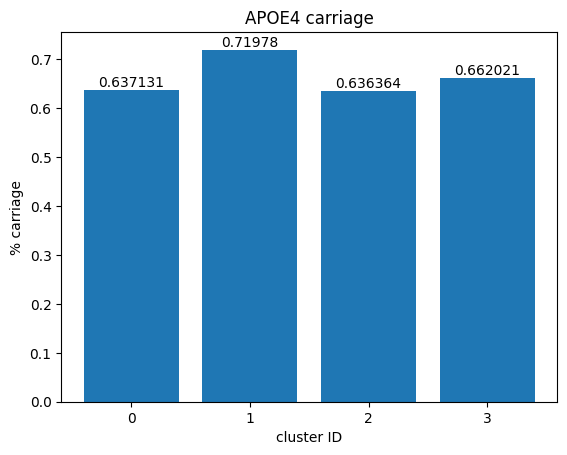

In [36]:
# APOE
fig, ax = plt.subplots()

means = [df[df['cluster'] == i]['apoe4'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('APOE4 carriage')
ax.set_xlabel('cluster ID')
ax.set_ylabel('% carriage')
ax.bar_label(bars)

print(means)

[1.4315208333333336, 1.2837142857142858, 1.4174057971014493, 1.4159333333333335]


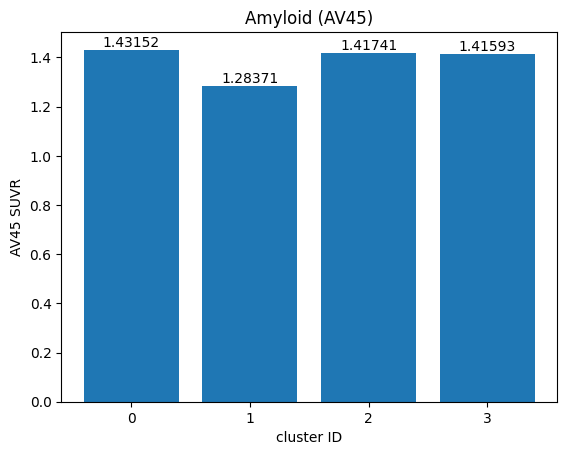

In [34]:
# AV45
fig, ax = plt.subplots()

# df[df['cluster'] == 0]['SUMMARY_SUVR'].hist(ax=ax[0], alpha=0.5)
# df[df['cluster'] == 1]['SUMMARY_SUVR'].hist(ax=ax[0], alpha=0.5)
# df[df['cluster'] == 2]['SUMMARY_SUVR'].hist(ax=ax[0], alpha=0.5)
# df[df['cluster'] == 3]['SUMMARY_SUVR'].hist(ax=ax[0], alpha=0.5)

means = [df[df['cluster'] == i]['SUMMARY_SUVR'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('Amyloid (AV45)')
ax.set_xlabel('cluster ID')
ax.set_ylabel('AV45 SUVR')
ax.bar_label(bars)

print(means)

In [ ]:
# APOE4 carriage
fig, ax = plt.subplots()

means = [df[df['cluster'] == i]['apoe4'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('Amyloid (AV45)')
ax.set_xlabel('cluster ID')
ax.set_ylabel('AV45 SUVR')
ax.bar_label(bars)

print(means)

[693.2535, 729.2313953488373, 624.4297297297297, 565.6023809523809]


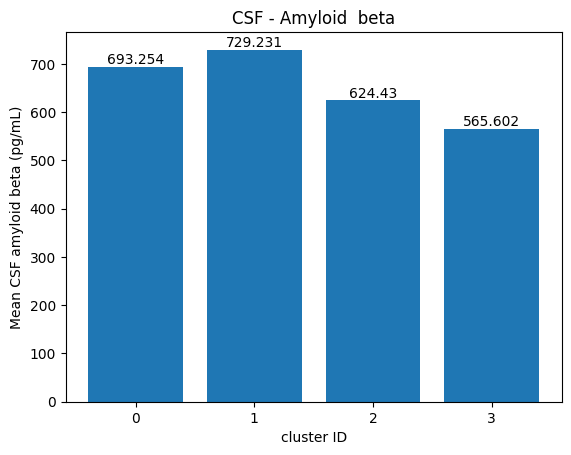

In [38]:
# CSF amyloid beta 
fig, ax = plt.subplots()

means = [df[df['cluster'] == i]['ABETA42'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('CSF - Amyloid  beta')
ax.set_xlabel('cluster ID')
ax.set_ylabel('Mean CSF amyloid beta (pg/mL)')
ax.bar_label(bars)

print(means)

[363.8260000000001, 394.6808139534883, 335.1594594594594, 307.86785714285713]


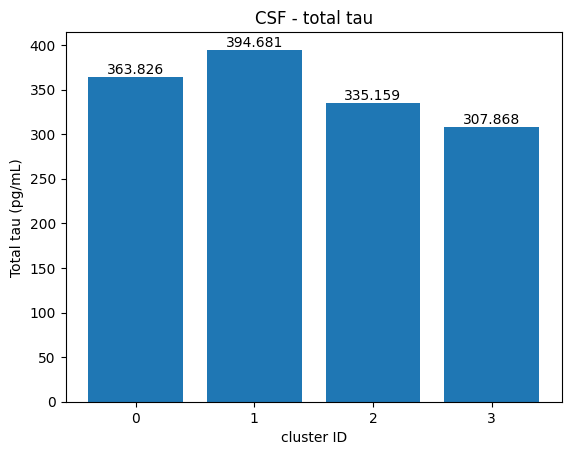

In [26]:
# CSF Total tau
fig, ax = plt.subplots()

means = [df[df['cluster'] == i]['TAU'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('CSF - total tau')
ax.set_xlabel('cluster ID')
ax.set_ylabel('Total tau (pg/mL)')
ax.bar_label(bars)

print(means)

[35.6097, 38.15888888888889, 32.93900900900901, 30.982619047619046]


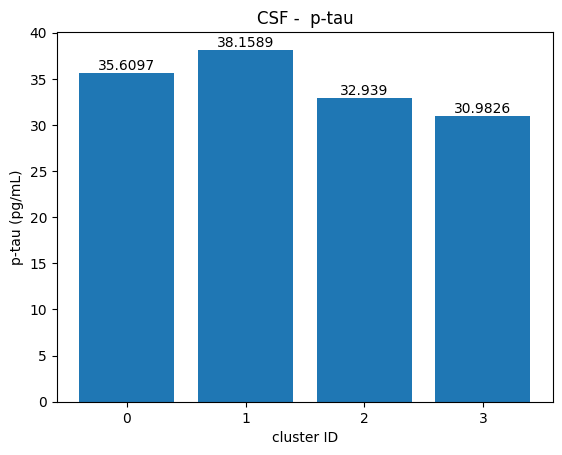

In [29]:
# p-tau
fig, ax = plt.subplots()

means = [df[df['cluster'] == i]['PTAU'].mean() for i in range(4)]
bars = ax.bar(range(4), means)
ax.set_xticks(range(4))
ax.set_xticklabels(range(4))
ax.set_title('CSF -  p-tau')
ax.set_xlabel('cluster ID')
ax.set_ylabel('p-tau (pg/mL)')
ax.bar_label(bars)

print(means)

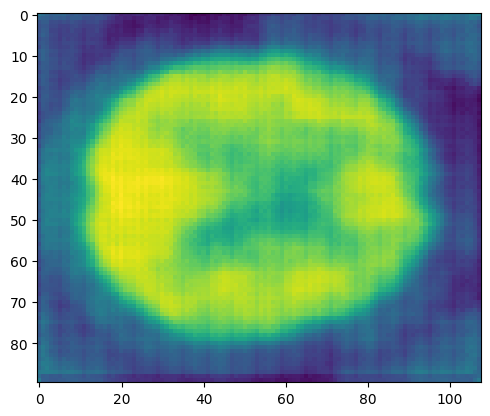

In [173]:
# Look at some sample results
with torch.no_grad():
    c = torch.Tensor(np.array([0.88])).to(DEVICE)

    sample = torch.randn(1, latent_dim).to(DEVICE)
    sample = model.decode(sample, c).cpu()
    plt.imshow(sample[0,0][:, :, 46])    

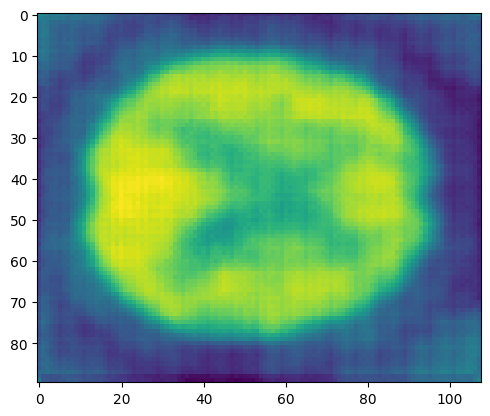

In [174]:
with torch.no_grad():
    c = torch.Tensor(np.array([0.05])).to(DEVICE)

    sample = torch.randn(1, latent_dim).to(DEVICE)
    sample = model.decode(sample, c).cpu()
    plt.imshow(sample[0,0][:, :, 46])    

In [175]:
# # Do we need padding???
# encoder = nn.Sequential(
#             nn.Conv3d(1, 16, (5,5,5), stride=2, padding=2),
#             nn.ReLU(),
#             nn.Conv3d(16, 16, (5,5,5), stride=3, padding=2),
#             nn.ReLU(),
#             nn.Conv3d(16, 64, (5,5,5), stride=3, padding=2),
#             nn.ReLU(),
#             nn.Conv3d(64, 64, (3,3,3)),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(2304, 32)
#         )        

In [176]:
# xx = torch.randn(16, 1, 90, 108, 90)
# encoder(x).shape

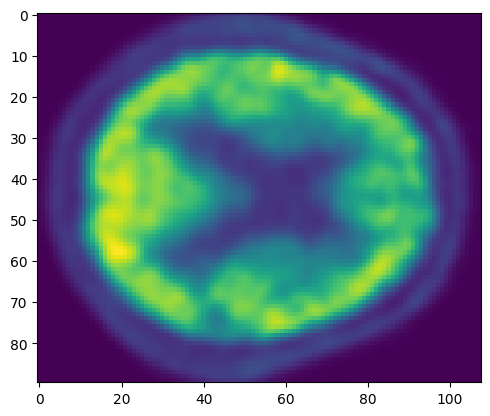

In [207]:
plt.imshow(dataset[0][0][0][:, :, 46])

In [213]:
x,y = dataset[0]
x = x.unsqueeze(0).to(DEVICE)
y = torch.tensor([0.05]).to(DEVICE)
model.eval()
with torch.no_grad():
    xhat, mu, logvar = model(x,y)
    z_sample = mu + torch.randn_like(logvar)*torch.exp(logvar/2)
    x_sample = model.decode(z_sample, y)

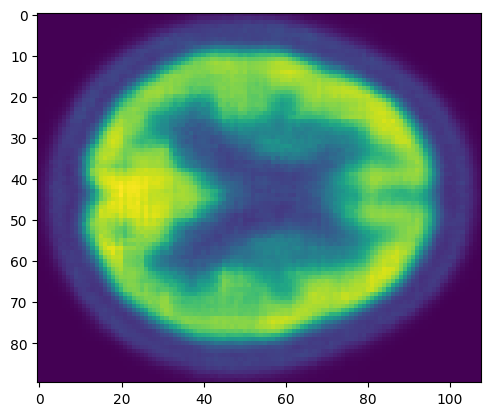

In [214]:
plt.imshow(x_sample[0,0,:,:,46].cpu())

In [215]:
cvae_loss_fn(x, xhat, mu, logvar)

kld: 69.76885223388672, bce: 282649.125


tensor(282718.9062, device='cuda:0')